In [14]:
import numpy as np
from util.plot import plot_cdf,color_list
from util.consts import balance_len_bins,balance_len_bins_label,balance_size_bins,balance_size_bins_label,get_base_delay_path,get_base_delay_transmission
import matplotlib.pyplot as plt
import json
import glob
import os
from collections import defaultdict

topo_type_ori="_topo-pl-x_"
lr=10
rotation_angle=30
np.random.seed(0)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


dir_train: /data2/lichenni/output_perflow/fct_path_200000_shard1000_nflows1_nhosts3_nsamples1_lr10Gbps/version_0/
/data2/lichenni/perflow_path loads 979 tracks
dir_train: /data2/lichenni/output_perflow/fct_path_200000_shard1000_nflows1_nhosts3_nsamples1_lr10Gbps/version_0/
/data2/lichenni/perflow_path_empirical loads 199 tracks


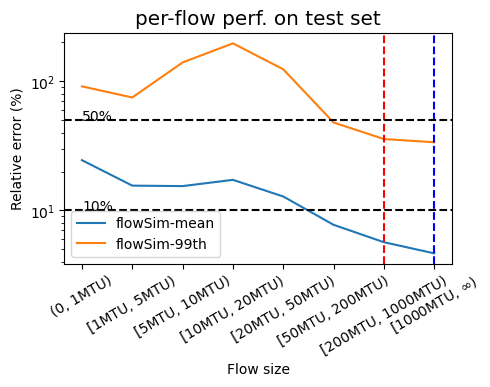

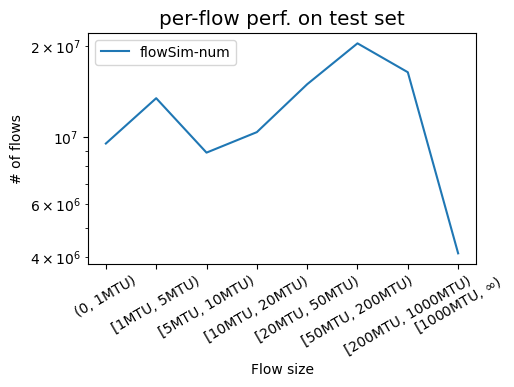

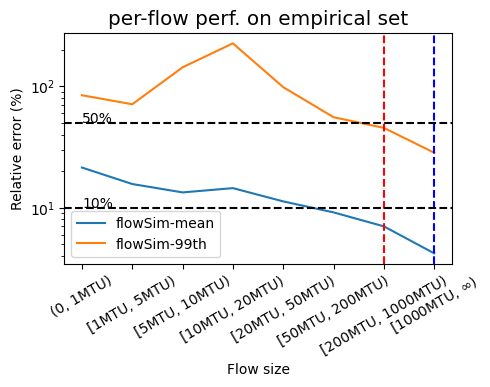

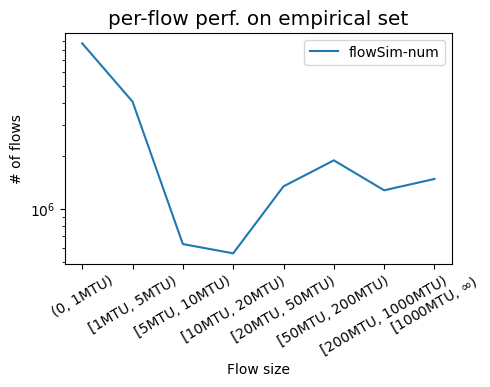

In [13]:
# the relationship between estimation error and flow size for flowSim
dir_input_synthetic="/data2/lichenni/perflow_path"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                'fct_path_200000_shard1000_nflows1_nhosts3_nsamples1_lr10Gbps',
                ]
version_id_list=[
    [0]
]
title_str_list = ["flowSim","m4"]
main_title_list=['test','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
for version_id_test in [0,1]:
    res_total_per_flow=[]
    fsize_total_per_flow=[]
    res_save=[]
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0:
                # f = open(f"{dir_train}/data_list.json", "r")
                # data_list = json.loads(f.read())
                # data_list_test=data_list["test"]
                # dir_input=dir_input_synthetic
                data_list_test=[]
                dir_input=dir_input_synthetic
                for shard in np.arange(1000):
                    for n_flows in [2000]:
                        for n_hosts in [5]:
                            for sample in [0]:
                                src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                                topo_type_cur = topo_type_ori.replace(
                                    "-x_", f"-{n_hosts}_"+f"s{sample}_i0"
                                )
                                spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                                # statss = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                                # if float(statss.item().get("size_sigma_candidate")) < 15000 or float(statss.item().get("size_sigma_candidate"))>40000: continue
                                
                                # print(statss.item())
                                # size_distribution_list=["cachefollower-all","hadoop-all","webserver-all"]
                                # if statss.item().get("size_dist_candidate") != 'webserver-all': continue
                                # if float(statss.item().get("load_bottleneck_target")) > 0.8: continue
                                # if float(statss.item().get("ias_sigma_candidate")) > 1.5: continue
                                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid) % n_flows == 0:
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur, None, None)
                                    )
            else:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                for shard in np.arange(200):
                    for n_flows in [2000]:
                        for n_hosts in [5]:
                            for sample in [0]:
                                src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                                topo_type_cur = topo_type_ori.replace(
                                    "-x_", f"-{n_hosts}_"+"s%d_i0"%(sample)
                                )
                                spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                                fid = np.load(f'{dir_input}/{spec}/fid{topo_type_cur}.npy')
                                # statss = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                                # print(statss.item())
                                # size_distribution_list=["cachefollower-all","hadoop-all","webserver-all"]
                                # if statss.item().get("size_dist_candidate") != 'webserver-all': continue
                                # if float(statss.item().get("load_bottleneck_target")) < 0.7: continue
                                # if float(statss.item().get("size_sigma_candidate")) < 15000 or float(statss.item().get("size_sigma_candidate"))>40000: continue
                                if len(fid)==len(set(fid)) and np.all(fid[:-1] <= fid[1:]) and len(fid) % n_flows == 0:
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur, None, None)
                                    )
                                
                                # pattern=os.path.join(
                                #         dir_train,
                                #         'test',
                                #         f'version_{version_id_test}',
                                #         f'{spec}{topo_type_cur}s{sample}_i0_{src_dst_pair_target_str}_seg*'
                                #     )
                                # matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                                # for matching_directory in matching_directories:
                                #     segment_id=matching_directory.split("_seg")[-1]
                                #     data_list_test.append(
                                #         (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}_i0", int(segment_id), None)
                                #     )
            
            len_tracks=len(data_list_test)
            print(f"{dir_input} loads {len_tracks} tracks")
            
            res_per_flow=[]
            fsize_per_flow=[]
            res_save_per_scenario=[]
            for spec, src_dst_pair_target, topo_type, segment_id, _ in data_list_test:
                dir_input_tmp=f"{dir_input}/{spec}"
                
                fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
                # busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}.npy", allow_pickle=True)
                # fid=np.array(busy_periods[segment_id])
                
                sizes = np.load(f"{dir_input_tmp}/fsize.npy")[fid]
                fsd = np.load(f"{dir_input_tmp}/fsd.npy")[fid]
                fid_ori = np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
                fid_idx = np.where(np.isin(fid_ori, fid))[0]
                if program_name_idx==0:
                    fcts_flowsim = np.load(f"{dir_input_tmp}/fct_flowsim.npy")[fid]
                    n_links_passed=abs(fsd[:, 0] - fsd[:, 1]) + 2
                    base_delay=get_base_delay_path(sizes,n_links_passed,lr)
                    i_fcts_flowsim = get_base_delay_transmission(sizes, lr) + base_delay
                    fcts_flowsim += base_delay
                    est = np.divide(fcts_flowsim, i_fcts_flowsim)
                else:
                    data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                    # gt = data['output'].flatten()
                    est = data['est'].flatten()
                fcts=np.load(f"{dir_input_tmp}/fct{topo_type}.npy")[fid_idx]
                fcts_i=np.load(f"{dir_input_tmp}/fct_i{topo_type}.npy")[fid_idx]
                gt=np.divide(fcts, fcts_i)
                
                # idx_sldn_one=np.where(gt>1.1)[0]
                
                # gt=gt[idx_sldn_one]
                # sizes=sizes[idx_sldn_one]
                # est=est[idx_sldn_one]
                
                if len(gt)==0:
                    print(f"empty gt: {spec}{topo_type}_{src_dst_pair_target_str}")
                    continue
                tmp=np.abs(gt - est)/gt*100
                res_per_flow.extend(tmp)
                fsize_per_flow.extend(sizes)
                res_save_per_scenario.append(tuple([est,sizes,gt]))
                
            res_total_per_flow.append(np.array(res_per_flow))
            fsize_total_per_flow.append(np.array(fsize_per_flow))
            res_save.append(res_save_per_scenario)
    # res_save=np.array(res_save).squeeze()
    # print(f"res_save: {np.array(res_save).shape}", dtype=object)
    res_save=np.array(res_save, dtype=object)
    np.save(f"./res/flowsim_path_{main_title_list[version_id_test]}.npy",res_save)
    fsize_total_per_flow=[np.digitize(x, balance_size_bins) for x in fsize_total_per_flow]
    
    # plt.figure(fig_index,figsize=(5, 3))
    # plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
    # for j in range(len(program_name_list)):
    #     plt.scatter(fsize_total_per_flow[j],res_total_per_flow[j],label=title_str_list[j],s=1)
    # plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
    # plt.legend()
    # # plt.xscale('log')
    # plt.xlabel("Flow size")
    # plt.ylabel(f"{metric_label_list[1]}")
    # fig_index+=1
    
    
    x=[]
    for j in range(len(program_name_list)):
        for i in range(len(balance_size_bins_label)):
            tmp=res_total_per_flow[j][fsize_total_per_flow[j]==i]
            x.append([np.mean(tmp),np.percentile(tmp,99), len(tmp)])
        x=np.array(x)
        
        plt.figure(fig_index,figsize=(5, 3))
        plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
        plt.plot(x[:,0],label=f"{title_str_list[0]}-mean")
        plt.plot(x[:,1],label=f"{title_str_list[0]}-99th")
        plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
        plt.legend()
       
        plt.xlabel("Flow size")
        plt.ylabel(f"{metric_label_list[1]}")
        plt.axvline(x=6, color='r', linestyle='--')
        plt.axvline(x=7, color='b', linestyle='--')
        plt.axhline(y=50, color='k', linestyle='--')
        plt.text(0, 50, '50%', color='k')
        plt.axhline(y=10, color='k', linestyle='--')
        plt.text(0, 10, '10%', color='k')
        plt.yscale('log')
        fig_index+=1
        
        plt.figure(fig_index,figsize=(5, 3))
        plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set", fontsize="x-large")

        plt.plot(x[:,2],label=f"{title_str_list[0]}-num")
        plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
        plt.legend()
       
        plt.xlabel("Flow size")
        plt.ylabel(f"# of flows")
        plt.yscale('log')
        fig_index+=1

In [17]:

dir_input_synthetic="/data2/lichenni/perflow_path"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                # 'path_100000000_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                # 'path_100000000_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps'
                ]
version_id_list=[
    [0],[0],[0],[0],[0]
]

title_str_list = ["flowSim","m4","m4-gnn","m4-1MB","m4-$\infty$"]
main_title_list=['test','empirical','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
for version_id_test in [0,1,2]:
    res_total_per_flow=[]
    size_total_per_flow=[]
    rank_total_per_flow=[]
    len_group_total_per_flow=[]
    
    res_total_per_seg=[]
    
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                data_list_test=data_list["test"]
                dir_input=dir_input_synthetic
            else:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                target_path=f'{dir_train}/test/version_{version_id_test}/'
                for shard in np.arange(200):
                    for n_flows in [2000]:
                        for n_hosts in [5]:
                            src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                            topo_type_cur = topo_type_ori.replace(
                                "-x_", f"-{n_hosts}_"
                            )
                            spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            # statss = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                            # print(statss.item())
                            # size_distribution_list=["cachefollower-all","hadoop-all","webserver-all"]
                            # if statss.item().get("size_dist_candidate") != 'webserver-all': continue
                            # if float(statss.item().get("load_bottleneck_target")) > 0.8: continue
                            # if float(statss.item().get("ias_sigma_candidate")) > 1.5: continue
                            
                            for sample in [0]:
                                pattern=os.path.join(
                                        dir_train,
                                        'test',
                                        f'version_{version_id_test}',
                                        f'{spec}{topo_type_cur}s{sample}_i0_{src_dst_pair_target_str}_seg*'
                                    )
                                matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                                for matching_directory in matching_directories:
                                    segment_id=matching_directory.split("_seg")[-1]
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}_i0", int(segment_id), None)
                                    )
            
            len_tracks=len(data_list_test)
            
            # if len(data_list_test)>20000:
            #     data_list_test_idx=np.random.choice(len(data_list_test),20000, replace=False)
            #     data_list_test=[data_list_test[i] for i in data_list_test_idx]
            
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_flow=[]
            size_per_flow=[]
            rank_per_flow=[]
            len_group_per_flow=[]
            
            res_per_seg=[]
            
            num_flows_to_gt=[]
            flow_size_threshold=int(program_name.split("_")[1])
            for spec, src_dst_pair_target, topo_type, segment_id, _ in data_list_test:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                
                dir_input_tmp=f"{dir_input}/{spec}"
                
                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}_t{flow_size_threshold}.npy", allow_pickle=True)
                busy_periods_time = np.load(
                    f"{dir_input_tmp}/period_time{topo_type}_t{flow_size_threshold}.npy"
                )
                fid_period=np.array(busy_periods[segment_id]).astype(int)
                fid_period = np.sort(fid_period)
                # fid=np.arange(int(busy_period[0]),int(busy_period[1])+1)
                period_start_time, period_end_time = busy_periods_time[segment_id]
                
                fid_ori = np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
                sizes = np.load(f"{dir_input_tmp}/fsize.npy")[fid_ori]
                fats = np.load(f"{dir_input_tmp}/fat.npy")[fid_ori]
                fsd = np.load(f"{dir_input_tmp}/fsd.npy")[fid_ori]
                fcts_flowsim = np.load(f"{dir_input_tmp}/fct_flowsim.npy")[fid_ori]
                # fid_idx = np.where(np.isin(fid_ori, fid))[0]
                # fid_idx=fid
                fid_period_idx = np.array(
                    [
                        np.where(fid_ori == ele)[0][0] if ele in fid_ori else -1
                        for ele in fid_period
                    ]
                )
                
                fid_rank=fid_period-np.min(fid_period)
                
                sizes=sizes[fid_period_idx]
                fats=fats[fid_period_idx]
                fsd=fsd[fid_period_idx]
                fcts_flowsim=fcts_flowsim[fid_period_idx]
                fcts=np.load(f"{dir_input_tmp}/fct{topo_type}.npy")[fid_period_idx]
                fcts_i=np.load(f"{dir_input_tmp}/fct_i{topo_type}.npy")[fid_period_idx]
                gt=np.divide(fcts, fcts_i)
                
                flag_flow_incomplete = np.array(fats + fcts > period_end_time)
                if program_name_idx==0:
                    n_links_passed=abs(fsd[:, 0] - fsd[:, 1]) + 2
                    base_delay=get_base_delay_path(sizes,n_links_passed,lr)
                    i_fcts_flowsim = get_base_delay_transmission(sizes,lr) + base_delay
                    fcts_flowsim += base_delay
                    est = np.divide(fcts_flowsim, i_fcts_flowsim)
                else:
                    data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                    est = data['est'].flatten()
                if len(gt)==1:
                    num_flows_to_gt.append([gt[0],est[0]])
                    
                gt=gt[~flag_flow_incomplete]
                est=est[~flag_flow_incomplete]
                sizes=sizes[~flag_flow_incomplete]
                fid_rank=fid_rank[~flag_flow_incomplete]
                
                # idx_sldn_one=np.where(gt>1.1)[0]
                # gt=gt[idx_sldn_one]
                # sizes=sizes[idx_sldn_one]
                # est=est[idx_sldn_one]
                # fid_rank=fid_rank[idx_sldn_one]
                
                if (len(gt)==0):
                    print(f"empty gt: {spec}{topo_type}_{src_dst_pair_target_str}")
                    continue
                res_tmp=np.abs(gt - est)/gt*100
                
                res_per_flow.extend(res_tmp)
                size_per_flow.extend(sizes)
                rank_per_flow.extend(fid_rank)
                len_group=np.digitize(len(fid_period), balance_len_bins)
                len_group_per_flow.extend([len_group]*len(sizes))
                assert len(res_tmp)==len(sizes)==len(fid_rank)
                res_per_seg.append([len(fid_period),np.median(res_tmp),np.percentile(res_tmp,99)]) 
                
            res_total_per_flow.append(res_per_flow)
            size_total_per_flow.append(size_per_flow)
            rank_total_per_flow.append(rank_per_flow)
            len_group_total_per_flow.append(len_group_per_flow)
            
            res_total_per_seg.append(res_per_seg)
            
    # res_total_per_flow=np.array(res_total_per_flow)
    # size_total_per_flow=np.array(size_total_per_flow)
    # rank_total_per_flow=np.array(rank_total_per_flow)
    # len_group_total_per_flow=np.array(len_group_total_per_flow)
    # res_total_per_seg=np.array(res_total_per_seg)
    # print(f"res_total_per_flow: {res_total_per_flow.shape}")
    # print(f"res_total_per_seg: {res_total_per_seg.shape}")
    
    res_total_per_flow=[np.array(x) for x in res_total_per_flow]
    size_total_per_flow=[np.array(x) for x in size_total_per_flow]
    rank_total_per_flow=[np.array(x) for x in rank_total_per_flow]
    len_group_total_per_flow=[np.array(x) for x in len_group_total_per_flow]
    res_total_per_seg=[np.array(x) for x in res_total_per_seg]
    
    enable_debug=False
    # for metric_idx in range(len(metric_label_list)):
    for metric_idx in [1]:
        # relationship between flow size and estimation error
        fsize_total_per_flow=[np.digitize(x, balance_size_bins) for x in size_total_per_flow]
        
        if enable_debug:
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                plt.scatter(fsize_total_per_flow[j],res_total_per_flow[j],label=title_str_list[j],s=1)
            plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
            plt.legend()
            # plt.xscale('log')
            plt.xlabel("flow size")
            plt.ylabel(f"{metric_label_list[1]}")
            fig_index+=1
        
        # relationship between flow size and mean/p99 estimation error
        x_total=[]
        for j in range(len(program_name_list)):
            x=[]
            for i in range(len(balance_size_bins_label)):
                tmp=res_total_per_flow[j][fsize_total_per_flow[j]==i]
                x.append([np.mean(tmp),np.percentile(tmp,99), len(tmp)])
            x_total.append(x)
        x_total=np.array(x_total)
        plt.figure(fig_index,figsize=(5, 3))
        plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
        for j in range(len(program_name_list)):
            plt.plot(x_total[j,:,0],label=f"{title_str_list[j]}-mean",color=color_list[j])
            plt.plot(x_total[j,:,1],label=f"{title_str_list[j]}-99th",color=color_list[j],linestyle='--')
        plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
        plt.legend(loc='upper right')
        plt.xlabel("flow size (byte)")
        plt.ylabel(f"{metric_label_list[1]}")
        plt.axvline(x=7, color='k', linestyle='--')
        plt.axvline(x=8, color='k', linestyle='--')
        plt.axhline(y=50, color='k', linestyle='--')
        plt.text(0, 50, '50%', color='k')
        plt.axhline(y=10, color='k', linestyle='--')
        plt.text(0, 10, '10%', color='k')
        plt.yscale('log')
        fig_index+=1
        
        if enable_debug:
            # relationship between # of flows and mean/p99 estimation error
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                plt.plot(x_total[j,:,2],label=f"{title_str_list[j]}",color=color_list[j])
            plt.xticks(ticks=np.arange(len(balance_size_bins_label)), labels=balance_size_bins_label,rotation=rotation_angle)
            plt.legend()
            plt.xlabel("flow size")
            plt.ylabel(f"# of flows")
            plt.yscale('log')
            fig_index+=1
        
            # relationship between rank and estimation error
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                plt.scatter(rank_total_per_flow[j],res_total_per_flow[j],label=title_str_list[j],s=1)
            plt.legend()
            # plt.xscale('log')
            plt.xlabel("Dist to the start of the period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1

            # relationship between rank and mean estimation error
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                stats_per_period=defaultdict(list)
                for i in range(len(res_total_per_flow[j])):
                    stats_per_period[rank_total_per_flow[j][i]].append(res_total_per_flow[j][i])
                stats_per_period=dict(sorted(stats_per_period.items()))
                x_list=list(stats_per_period.keys())
                y_list=[np.mean(stats_per_period[key]) for key in stats_per_period.keys()]
                plt.plot(x_list,y_list,label=f"{title_str_list[j]}-mean")
            plt.legend()
            # plt.xscale('log')
            plt.xlabel("Dist to the start of the period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1
         
        # relationship between rank and mean estimation error for different period length
        for k in range(len(balance_len_bins_label)):
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-flow perf. on {main_title_list[version_id_test]} set for period-{balance_len_bins_label[k]}", fontsize="x-large")
            for j in range(len(program_name_list)):
                stats_per_period=defaultdict(list)
                for i in range(len(res_total_per_flow[j])):
                    if len_group_total_per_flow[j][i]==k:
                        stats_per_period[rank_total_per_flow[j][i]].append(res_total_per_flow[j][i])
                stats_per_period=dict(sorted(stats_per_period.items()))
                x_list=list(stats_per_period.keys())
                y_list=[np.mean(stats_per_period[key]) for key in stats_per_period.keys()]
                plt.plot(x_list,y_list,label=f"{title_str_list[j]}-mean")
            plt.legend()
            # plt.xscale('log')
            plt.xlabel("Dist to the start of the period")
            # plt.ylim(0,90)
            plt.ylabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1
        
        # per period
        # relationship between period length and mean/p99 estimation error
        len_total_per_seg=np.array([np.digitize(x[:,0], balance_len_bins) for x in res_total_per_seg])
        
        if enable_debug:
            plt.figure(fig_index,figsize=(5, 3))
            plt.title(f"per-period perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
            for j in range(len(program_name_list)):
                plt.scatter(len_total_per_seg[j],res_total_per_seg[j][:,1],label=title_str_list[j],s=1)
            plt.legend()
            plt.xticks(ticks=np.arange(len(balance_len_bins_label)), labels=balance_len_bins_label,rotation=rotation_angle)
            # plt.xscale('log')
            plt.xlabel("# of flows per period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
            fig_index+=1
        
        # relationship between period length and mean/p99 estimation error
        plt.figure(fig_index,figsize=(5, 3))
        plt.title(f"per-period perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res_total_per_seg[j][:,1])):
                stats_per_period[len_total_per_seg[j][i]].append(res_total_per_seg[j][i,1])
            stats_per_period=dict(sorted(stats_per_period.items()))
            x_list=list(stats_per_period.keys())
            y_list=[np.mean(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-mean")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_len_bins_label)), labels=balance_len_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        # relationship between period length and # of periods
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"per-period perf. on {main_title_list[version_id_test]} set", fontsize="x-large")
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res_total_per_seg[j][:,1])):
                stats_per_period[len_total_per_seg[j][i]].append(res_total_per_seg[j][i,1])
            stats_per_period=dict(sorted(stats_per_period.items()))
            x_list=list(stats_per_period.keys())
            y_list=[len(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_len_bins_label)), labels=balance_len_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"# of periods")
        fig_index+=1
        
        if enable_debug:
            plot_cdf(
                np.array(num_flows_to_gt).transpose(),
                None,
                ['GT', 'EST'],
                x_label="Sldn of flows in single-flow periods",
                log_switch=False,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                enable_abs=True,
                group_size=5,
                fig_idx=fig_index
            )
            fig_index+=1
        

dir_train: /data2/lichenni/output_perflow/path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 2016 tracks
dir_train: /data2/lichenni/output_perflow/path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 2016 tracks
dir_train: /data2/lichenni/output_perflow/path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 3974 tracks
dir_train: /data2/lichenni/output_perflow/path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
path_1000000_shard1000_nflows1_nhosts1_nsamples1_lr10Gbps loads 3974 tracks
